### Data Analysis Interview Challenge (Ultimate Technologies)
Please consider this notebook my formal submission for the Ultimate Technologies Take Home Challenge. Each section of the challenge will be contained in this notebook

## 1) Exploratory Data Analysis

The assignment is as follows:

_The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them._

### 1.1 - Importing and Processing

In [1]:
# Import Initial Relevant Base Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import json # We also will import json given that we are working with JSON files

In [2]:
# First, we need to import the appropriate JSOM file from the packge
with open('logins.json') as f:
    raw_data = json.load(f)

In [3]:
# Second, let's consider making a DataFrame to make it easier to work with the data
raw_df = pd.DataFrame(raw_data)
raw_df.head(5)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
# Third, let's figure out the max and minimum to see how long the range is. We can use describe for this.
print(raw_df.login_time.min())
print(raw_df.login_time.max())

1970-01-01 20:12:16
1970-04-13 18:57:38


We can see that the first login is on Januaray 1st, 1970 at 20:12:16 and the last login is April 13th at 18:57:38 which gives us some information. That said, let's do a little quality control to make sure everything is workable and as it seems.

### Note of concern
**One concern may be that this data comes from 'year' 1970 which may be suspect since electronic regards may have not been particularly prevalent. It would make sense to consider discussing with the data manager if this data is accurately dated. This would potentially impact any inferences we were to make based on the day of the week (e.g., Mondays) as we would need the year to be accurate**

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [6]:
raw_df.isna().value_counts()

login_time
False         93142
dtype: int64

In [7]:
type(raw_df['login_time'][0])

str

All of this data together gives us some important information:
* It's clear that the time stamps are not sorted chronologically as the earliest stamp is not the first time stamp using the head() method.
* We may need to consider how we want to aggreate our data is the element is a string (which is confirmation something is up given that the Dtype is an object. This also makes sense given that we are working with a JSON file.
* It would appear that there are no "empty" values but we should keep an eye out for any elements that may be misformatted

In [8]:
#One thing we can also do to help ourselves is have an ISO date and ISO time string that we can use to make date time objects
raw_df['iso_date'] = raw_df['login_time'].str[0:10]
raw_df['iso_time'] = raw_df['login_time'].str[11:19]

In [9]:
#Now let's make some date time objects that can hopefully help us out
raw_df['dateobj'] = pd.to_datetime(raw_df['iso_date'],format='%Y-%m-%d')
raw_df['timeobj']=pd.to_datetime(raw_df['iso_time'],format='%H:%M:%S')

In [10]:
# Let's consider that we may be best served creating
#a few features that help us parse through the timestamps to help us with aggregation work
#To start with, let's consider the year
raw_df['year'] = raw_df['login_time'].str[0:4]

In [11]:
# Now let's consider month
raw_df['month'] = raw_df['login_time'].str[5:7]

In [12]:
# Now let's consider day
raw_df['day'] = raw_df['login_time'].str[8:10]

In [13]:
# Let's check unique values for these features to verify that there isn't anything odd we need to consider
#We'll start with year
print(raw_df['year'].unique())

['1970']


In [14]:
#Let's consider month
print(raw_df['month'].unique())

['01' '02' '03' '04']


In [15]:
#Let's consider day
print(raw_df['day'].unique())

['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28'
 '29' '30' '31']


As far as we can see, the year, month, and day seem to be completely okay and we don't see any reason to believe there is something wrong with the data we were given

In [16]:
# We can then work through the hour, minute, and second component of the login
#To start with, let's consider the hour
raw_df['hour'] = raw_df['login_time'].str[11:13]

In [17]:
# let's consider the minute
raw_df['minute'] = raw_df['login_time'].str[14:16]

In [18]:
# finally, let's consider the second
raw_df['second'] = raw_df['login_time'].str[17:19]

In [19]:
#Take a look at the unique values to see if anything is odd
raw_df['hour'].unique()

array(['20', '21', '22', '23', '00', '01', '02', '03', '04', '05', '06',
       '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19'], dtype=object)

In [20]:
#Take a look at the unique values to see if anything is odd
raw_df['minute'].unique()

array(['13', '16', '26', '21', '12', '35', '47', '31', '34', '36', '39',
       '40', '43', '46', '56', '49', '59', '15', '09', '19', '20', '29',
       '58', '51', '08', '02', '05', '10', '11', '01', '17', '23', '22',
       '25', '24', '06', '55', '07', '04', '57', '14', '18', '33', '30',
       '38', '45', '37', '52', '27', '44', '41', '53', '48', '50', '03',
       '32', '28', '42', '54', '00'], dtype=object)

In [21]:
#Take a look at the unique values to see if anything is odd
raw_df['second'].unique()

array(['18', '10', '37', '36', '21', '41', '16', '47', '38', '52', '05',
       '03', '46', '34', '25', '58', '59', '07', '12', '06', '01', '24',
       '53', '19', '51', '40', '32', '31', '28', '54', '14', '09', '04',
       '11', '56', '35', '55', '00', '13', '22', '30', '45', '48', '43',
       '57', '50', '17', '27', '02', '29', '39', '42', '23', '49', '26',
       '44', '08', '20', '33', '15'], dtype=object)

In [22]:
#One small addition we can make is a "month-day" feature than can give us an easy index we can work with as well
raw_df['month_day'] = raw_df.agg(lambda x: f"{x['month']}-{x['day']}", axis=1)

As far as we can see up this point, things seem to be moving along nicely. One consideration we have as of now is that all of our features are strings which we'll address because it will enable sorting to be easier

In [23]:
#Let's recast our new features to be integers
raw_df['year'] = raw_df['year'].astype(int)
raw_df['month'] = raw_df['month'].astype(int)
raw_df['day'] = raw_df['day'].astype(int)
raw_df['hour'] = raw_df['hour'].astype(int)
raw_df['minute'] = raw_df['minute'].astype(int)
raw_df['second'] = raw_df['second'].astype(int)

In [24]:
#let's check their types
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  object        
 1   iso_date    93142 non-null  object        
 2   iso_time    93142 non-null  object        
 3   dateobj     93142 non-null  datetime64[ns]
 4   timeobj     93142 non-null  datetime64[ns]
 5   year        93142 non-null  int32         
 6   month       93142 non-null  int32         
 7   day         93142 non-null  int32         
 8   hour        93142 non-null  int32         
 9   minute      93142 non-null  int32         
 10  second      93142 non-null  int32         
 11  month_day   93142 non-null  object        
dtypes: datetime64[ns](2), int32(6), object(4)
memory usage: 6.4+ MB


In [25]:
#Do a visual check
raw_df.head()

,login_time,iso_date,iso_time,dateobj,timeobj,year,month,day,hour,minute,second,month_day
0,1970-01-01 20:13:18,1970-01-01,20:13:18,1970-01-01,1900-01-01 20:13:18,1970,1,1,20,13,18,01-01
1,1970-01-01 20:16:10,1970-01-01,20:16:10,1970-01-01,1900-01-01 20:16:10,1970,1,1,20,16,10,01-01
2,1970-01-01 20:16:37,1970-01-01,20:16:37,1970-01-01,1900-01-01 20:16:37,1970,1,1,20,16,37,01-01
3,1970-01-01 20:16:36,1970-01-01,20:16:36,1970-01-01,1900-01-01 20:16:36,1970,1,1,20,16,36,01-01
4,1970-01-01 20:26:21,1970-01-01,20:26:21,1970-01-01,1900-01-01 20:26:21,1970,1,1,20,26,21,01-01


In [26]:
#It may also be useful to know which day of the week our observations fall on
raw_df['day_of_week'] = raw_df['dateobj'].dt.dayofweek

In [27]:
raw_df

,login_time,iso_date,iso_time,dateobj,timeobj,year,month,day,hour,minute,second,month_day,day_of_week
0,1970-01-01 20:13:18,1970-01-01,20:13:18,1970-01-01,1900-01-01 20:13:18,1970,1,1,20,13,18,01-01,3
1,1970-01-01 20:16:10,1970-01-01,20:16:10,1970-01-01,1900-01-01 20:16:10,1970,1,1,20,16,10,01-01,3
2,1970-01-01 20:16:37,1970-01-01,20:16:37,1970-01-01,1900-01-01 20:16:37,1970,1,1,20,16,37,01-01,3
3,1970-01-01 20:16:36,1970-01-01,20:16:36,1970-01-01,1900-01-01 20:16:36,1970,1,1,20,16,36,01-01,3
4,1970-01-01 20:26:21,1970-01-01,20:26:21,1970-01-01,1900-01-01 20:26:21,1970,1,1,20,26,21,01-01,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93137,1970-04-13 18:50:19,1970-04-13,18:50:19,1970-04-13,1900-01-01 18:50:19,1970,4,13,18,50,19,04-13,0
93138,1970-04-13 18:43:56,1970-04-13,18:43:56,1970-04-13,1900-01-01 18:43:56,1970,4,13,18,43,56,04-13,0
93139,1970-04-13 18:54:02,1970-04-13,18:54:02,1970-04-13,1900-01-01 18:54:02,1970,4,13,18,54,2,04-13,0
93140,1970-04-13 18:57:38,1970-04-13,18:57:38,1970-04-13,1900-01-01 18:57:38,1970,4,13,18,57,38,04-13,0


### 1.2 Grouping

The assignment requires we group by 15 minute intervals. As such, we can consider the following baseline for grouping within an hour:
* Group 1: 00 >= and < 15 minutes
* Group 2: 15 >= and < 30 minutes
* Group 3: 30 >= and < 45 minutes
* Group 3: 45 >= and < 60 minutes

This means our groupings will be "left side inclusive but right side exclusive" and within an hour there will be 4 buckets. Since we know that the first login is on Januaray 1st, 1970 at 20:12:16 and the last login is April 13th at 18:57:38, we also can figure out how many buckets we'll need. We'll have our first bucket be January 1st from 20:00 to 20:15 (which will include the first observations) and our last bucket be April 13th from 18:45 to 18:60.

However, in order to do this properly, we'll need to consider somethings:
* First, each month has a different number of days so it would not be a nice periodic count.
* 1970 is not a leap year so we do not need to consider that either. 
* There are multiple ways we can group our observations that we should consider

In specific regarding grouping, we could group in the following ways:
* Based on days passed (so you would have a group that represents month and day and another group that represents 15 minute interval (e.g., February 2nd @ 0035 would be group 33 for 33 days passed and group 2 for 0035)
* You could have each group be completely unique (i.e., just start counting in 15 minute intervals until complete)

This is useful since if we count how many days have passed, we can more or less calculate both relatively easily

In [28]:
# First, let's make a days passed feature that allows us to see how many days have passed since January 1st
#We'll call it days_count
raw_df['days_count'] = pd.to_datetime(raw_df['dateobj']) - pd.to_datetime(raw_df['dateobj'][0]) #Since the first entry is Jan 1st

In [29]:
# Second, let's make a "daily group" feature that denotes an observation where it falls in a daily cycle of 1-96
raw_df['daily_group'] = ((raw_df['hour'] * 4) + (raw_df['minute'] // 15)) + 1

The math works as follows: Since each hour can contain 4 groups and hours are counted 0-23, we can multiple the hours by 4 to "advance" the count properly for the hours. Then, we know each group is split by 15 minute denominations, so we can use the quotient operator to get the proper grouping within an hour. Finally we add one since our count starts at one, not zero

In [30]:
# Third, let's make an "aggregate_group" feature that denotes where an observation 
#falls uniquely in 15 minute intervals for the entire data set

#First, we'll do this assuming the first group starts January 1st at 00:00
holder = raw_df['days_count'].dt.days #We do this to cast as integers to make calculations easier
raw_df['days_count_int'] = holder #We may as well make this a feature to work with as well

In [31]:
#Advance the count by the number of days passed
raw_df['agg_group'] = (holder * 96) + raw_df['daily_group']

In [32]:
#Let's check our dataframe
raw_df.head()

,login_time,iso_date,iso_time,dateobj,timeobj,year,month,day,hour,minute,second,month_day,day_of_week,days_count,daily_group,days_count_int,agg_group
0,1970-01-01 20:13:18,1970-01-01,20:13:18,1970-01-01,1900-01-01 20:13:18,1970,1,1,20,13,18,01-01,3,0 days,81,0,81
1,1970-01-01 20:16:10,1970-01-01,20:16:10,1970-01-01,1900-01-01 20:16:10,1970,1,1,20,16,10,01-01,3,0 days,82,0,82
2,1970-01-01 20:16:37,1970-01-01,20:16:37,1970-01-01,1900-01-01 20:16:37,1970,1,1,20,16,37,01-01,3,0 days,82,0,82
3,1970-01-01 20:16:36,1970-01-01,20:16:36,1970-01-01,1900-01-01 20:16:36,1970,1,1,20,16,36,01-01,3,0 days,82,0,82
4,1970-01-01 20:26:21,1970-01-01,20:26:21,1970-01-01,1900-01-01 20:26:21,1970,1,1,20,26,21,01-01,3,0 days,82,0,82


In [33]:
raw_df.tail()

,login_time,iso_date,iso_time,dateobj,timeobj,year,month,day,hour,minute,second,month_day,day_of_week,days_count,daily_group,days_count_int,agg_group
93137,1970-04-13 18:50:19,1970-04-13,18:50:19,1970-04-13,1900-01-01 18:50:19,1970,4,13,18,50,19,04-13,0,102 days,76,102,9868
93138,1970-04-13 18:43:56,1970-04-13,18:43:56,1970-04-13,1900-01-01 18:43:56,1970,4,13,18,43,56,04-13,0,102 days,75,102,9867
93139,1970-04-13 18:54:02,1970-04-13,18:54:02,1970-04-13,1900-01-01 18:54:02,1970,4,13,18,54,2,04-13,0,102 days,76,102,9868
93140,1970-04-13 18:57:38,1970-04-13,18:57:38,1970-04-13,1900-01-01 18:57:38,1970,4,13,18,57,38,04-13,0,102 days,76,102,9868
93141,1970-04-13 18:54:23,1970-04-13,18:54:23,1970-04-13,1900-01-01 18:54:23,1970,4,13,18,54,23,04-13,0,102 days,76,102,9868


One note is that if we want to "align" the agg_group feature with that actual start of our data, we could subtract 80 from it, which we'll make as our last feature as our first group starts at 20:00

In [34]:
#Have the 1st group align with the earliest observation in our data
raw_df['agg_group_align'] = raw_df['agg_group'] - 80

In [35]:
raw_df.head()

,login_time,iso_date,iso_time,dateobj,timeobj,year,month,day,hour,minute,second,month_day,day_of_week,days_count,daily_group,days_count_int,agg_group,agg_group_align
0,1970-01-01 20:13:18,1970-01-01,20:13:18,1970-01-01,1900-01-01 20:13:18,1970,1,1,20,13,18,01-01,3,0 days,81,0,81,1
1,1970-01-01 20:16:10,1970-01-01,20:16:10,1970-01-01,1900-01-01 20:16:10,1970,1,1,20,16,10,01-01,3,0 days,82,0,82,2
2,1970-01-01 20:16:37,1970-01-01,20:16:37,1970-01-01,1900-01-01 20:16:37,1970,1,1,20,16,37,01-01,3,0 days,82,0,82,2
3,1970-01-01 20:16:36,1970-01-01,20:16:36,1970-01-01,1900-01-01 20:16:36,1970,1,1,20,16,36,01-01,3,0 days,82,0,82,2
4,1970-01-01 20:26:21,1970-01-01,20:26:21,1970-01-01,1900-01-01 20:26:21,1970,1,1,20,26,21,01-01,3,0 days,82,0,82,2


In [36]:
raw_df.tail()

,login_time,iso_date,iso_time,dateobj,timeobj,year,month,day,hour,minute,second,month_day,day_of_week,days_count,daily_group,days_count_int,agg_group,agg_group_align
93137,1970-04-13 18:50:19,1970-04-13,18:50:19,1970-04-13,1900-01-01 18:50:19,1970,4,13,18,50,19,04-13,0,102 days,76,102,9868,9788
93138,1970-04-13 18:43:56,1970-04-13,18:43:56,1970-04-13,1900-01-01 18:43:56,1970,4,13,18,43,56,04-13,0,102 days,75,102,9867,9787
93139,1970-04-13 18:54:02,1970-04-13,18:54:02,1970-04-13,1900-01-01 18:54:02,1970,4,13,18,54,2,04-13,0,102 days,76,102,9868,9788
93140,1970-04-13 18:57:38,1970-04-13,18:57:38,1970-04-13,1900-01-01 18:57:38,1970,4,13,18,57,38,04-13,0,102 days,76,102,9868,9788
93141,1970-04-13 18:54:23,1970-04-13,18:54:23,1970-04-13,1900-01-01 18:54:23,1970,4,13,18,54,23,04-13,0,102 days,76,102,9868,9788


In [37]:
# One last thing we can do to make our lives easier is to sort our data to be chronological. However, we'll move this
#to a new Dataframe to so we don't manipulate the raw data that we can always refer back to if necessary
raw_sorted_df = raw_df.sort_values(by=['month','day','hour','minute','second'])

In [38]:
raw_sorted_df.head()

,login_time,iso_date,iso_time,dateobj,timeobj,year,month,day,hour,minute,second,month_day,day_of_week,days_count,daily_group,days_count_int,agg_group,agg_group_align
6,1970-01-01 20:12:16,1970-01-01,20:12:16,1970-01-01,1900-01-01 20:12:16,1970,1,1,20,12,16,01-01,3,0 days,81,0,81,1
0,1970-01-01 20:13:18,1970-01-01,20:13:18,1970-01-01,1900-01-01 20:13:18,1970,1,1,20,13,18,01-01,3,0 days,81,0,81,1
1,1970-01-01 20:16:10,1970-01-01,20:16:10,1970-01-01,1900-01-01 20:16:10,1970,1,1,20,16,10,01-01,3,0 days,82,0,82,2
3,1970-01-01 20:16:36,1970-01-01,20:16:36,1970-01-01,1900-01-01 20:16:36,1970,1,1,20,16,36,01-01,3,0 days,82,0,82,2
2,1970-01-01 20:16:37,1970-01-01,20:16:37,1970-01-01,1900-01-01 20:16:37,1970,1,1,20,16,37,01-01,3,0 days,82,0,82,2


### 1.3 Daily Group Analysis

We now have many features to capture a multitude of aspects of our observations and a sorted version to allow for easier analysis when appropriate. Now that we've "wrangled" our data, we can start consider some some EDA to gain some understanding of our data! Let's first start looking at the data on a "day by day" level just to get a macro sense of it before we dive into the 15 minutes intervals

In [39]:
# First, let's get a sense of our data simply based on month and day without considering
#the 15 minute intervals. We can use the days_count_int column to proxy this easily
dailycounts_df = raw_sorted_df[['month','day','days_count_int']].groupby('days_count_int').count()

In [40]:
# Second, let's make a bar graph to see how the data changes daily as this will
#also be a good "backdrop" when we start considering more granular data
#fig = plt.figure(figsize = (20,10))
#plt.bar(dailycounts_df.index, dailycounts_df.day)

([<matplotlib.axis.XTick at 0x20e121912e0>,
 [Text(0, 0, '01-01'),
  Text(1, 0, '01-02'),
  Text(2, 0, '01-03'),
  Text(3, 0, '01-04'),
  Text(4, 0, '01-05'),
  Text(5, 0, '01-06'),
  Text(6, 0, '01-07'),
  Text(7, 0, '01-08'),
  Text(8, 0, '01-09'),
  Text(9, 0, '01-10'),
  Text(10, 0, '01-11'),
  Text(11, 0, '01-12'),
  Text(12, 0, '01-13'),
  Text(13, 0, '01-14'),
  Text(14, 0, '01-15'),
  Text(15, 0, '01-16'),
  Text(16, 0, '01-17'),
  Text(17, 0, '01-18'),
  Text(18, 0, '01-19'),
  Text(19, 0, '01-20'),
  Text(20, 0, '01-21'),
  Text(21, 0, '01-22'),
  Text(22, 0, '01-23'),
  Text(23, 0, '01-24'),
  Text(24, 0, '01-25'),
  Text(25, 0, '01-26'),
  Text(26, 0, '01-27'),
  Text(27, 0, '01-28'),
  Text(28, 0, '01-29'),
  Text(29, 0, '01-30'),
  Text(30, 0, '01-31'),
  Text(31, 0, '02-01'),
  Text(32, 0, '02-02'),
  Text(33, 0, '02-03'),
  Text(34, 0, '02-04'),
  Text(35, 0, '02-05'),
  Text(36, 0, '02-06'),
  Text(37, 0, '02-07'),
  Text(38, 0, '02-08'),
  Text(39, 0, '02-09'),
  Text

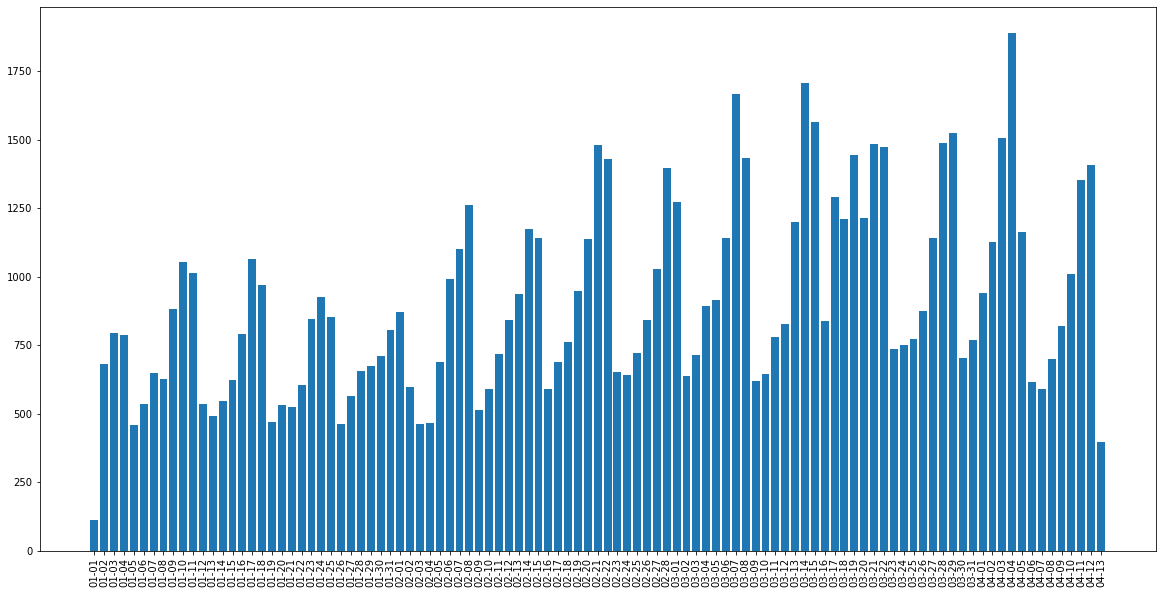

In [41]:
# Second, let's make a bar graph to see how the data changes daily as this will
#also be a good "backdrop" when we start considering more granular data
fig = plt.figure(figsize = (20,10))
plt.bar(dailycounts_df.index, dailycounts_df.day)
plt.xticks(ticks = dailycounts_df.index, labels = raw_sorted_df['month_day'].unique(), rotation = 90)

Off the bat, we can see that there is some sort of cyclical pattern to the data at the daily level. If we start at the drop associated with 01-05, we can see the next big drop happens after 7 days on 01-12, and the pattern seems to hold moving forward. This would imply there is a potential weekly cyclical element to our data that we could potentially need to address.

Since this data appears to have some interesting daily trends, let's take a moment to treat it like a time series model that has a daily frequency to run some basic analysis

In [42]:
# First, we'll need to make a new DataFrame that is suitable to running Time Series analysis
#Let's build the commesurate pieces and then we'll package them together into DataFrame

timeSeries_dates = raw_sorted_df['iso_date'].unique() #Gives us our dates
timeSeries_dates = pd.to_datetime(timeSeries_dates) #Change to Date 
timeSeries_values = dailycounts_df.day #Gives us our counts
daily_timeSeries_df = pd.DataFrame(index = timeSeries_dates) #Create Dataframe with Index
daily_timeSeries_df['Counts'] = timeSeries_values.values #Attached Daily Login Counts

In [43]:
daily_timeSeries_df.head()

,Counts
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


We now have a DataFrame that we can use to do basic Time Series analysis on a daily level. Let's consider a few ways to examine our data, with the first being auto-correlation.

The first pair of statistics to look at are the auto-correlation measures for the raw counts and the percentage changes

In [44]:
# Compute and print the auto-correlation for the raw counts
autocorrelation = daily_timeSeries_df['Counts'].autocorr()
print("The autocorrelation of daily logins raw counts is %4.2f" %(autocorrelation))

The autocorrelation of daily logins raw counts is 0.56


In [45]:
#Let's make a pct-change version of our DataFrame
daily_timeSeries_pctChange_df = daily_timeSeries_df.pct_change()
#Compute and print the auto-correlation
autocorrelation = daily_timeSeries_pctChange_df['Counts'].autocorr()
print("The autocorrelation of daily logins is %4.2f" %(autocorrelation))

The autocorrelation of daily logins is 0.10


These two stats give us some fairly useful information about our daily time series. First, if we are working strictly on raw counts, we can see that there is a strong momemntum aspect of the data. Even if we scale it via percentage chances, we still see the momemntum aspect (although quite less) in the data. This suggests that the values are tending to grow over time.

We can also check the auto-correlation function plots for the raw counts and percentgaes to get a sense of how to predict future values from past values

In [46]:
# Import relevant packages
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


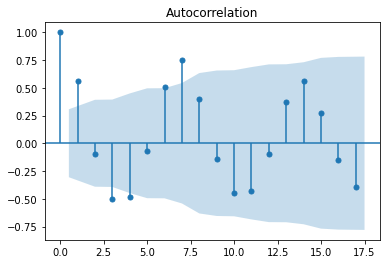

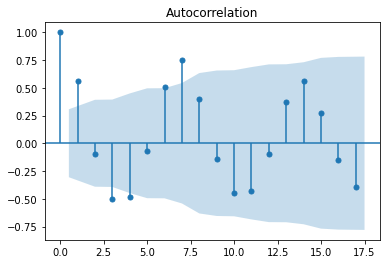

In [47]:
#Let's look at the ACF based on the raw counts
countArray = acf(daily_timeSeries_df.dropna())
plot_acf(countArray, alpha=0.05)

C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


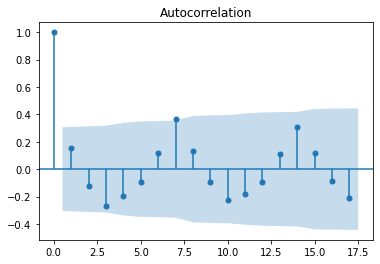

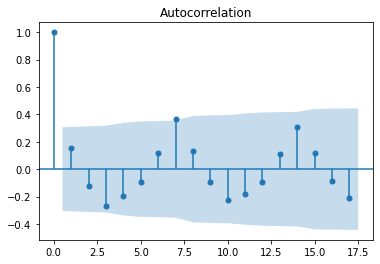

In [48]:
#Let's look at the ACF based on the percentage changes
countArray = acf(daily_timeSeries_pctChange_df.dropna())
plot_acf(countArray, alpha=0.05)

So these graphs give us some interesting information as well. In terms of percentage changes, we can't really determine the change from pervious amounts. The only exception is potentially the 7th lag term which is the cyclical nature of the data set coming through. If we look at the raw count ACF function, we can see that the 1st, 2nd and 7th terms seem to have quite some explanatory power which would imply there is a trend that can be determined if working with raw numbers.

We can also use the Dickey Fuller test to get a sense of whether our daily data series is a random walk or not

In [49]:
# Import relevant packages
from statsmodels.tsa.stattools import adfuller

In [50]:
#Create an array that works withe Dickey Fuller Test & Run the test
changesVector = daily_timeSeries_pctChange_df.Counts.dropna()
results = adfuller(changesVector)

In [51]:
print(results)

(-4.6750073838449175, 9.373642436773403e-05, 12, 89, {'1%': -3.506057133647011, '5%': -2.8946066061911946, '10%': -2.5844100201994697}, -53.4800277360477)


We can see here that the p-value is less than 5% and the beta coefficient is negative. Therefore, we can safely assume that on a daily basis, our series does not act like an random walk and therefore we can consider that it has some drift with it.

### 1.4) 15 minute interval group analysis

We'll now explore the 15 minute interval groups per the question now that we have a grasp on how the data works on a macro level.

In [52]:
# First, let's calculate some summary statistics at the group level.
# Create a DataFrame that allows for counts
intraDayGroup_df = raw_sorted_df[['month_day','daily_group','iso_date']].groupby(['month_day','daily_group']).count()
#Now let's build the means group first
intraDayGroupStats_df = intraDayGroup_df.groupby('daily_group').mean()
#Rename to make more clear
intraDayGroupStats_df.columns = ['daily_group_mean']

In [53]:
#Let's add in some more stats

#Standard Deviation
statHolder = intraDayGroup_df.groupby('daily_group').std()
intraDayGroupStats_df['daily_group_std'] = statHolder.values

#Min
statHolder = intraDayGroup_df.groupby('daily_group').min()
intraDayGroupStats_df['daily_group_min'] = statHolder.values

#Max
statHolder = intraDayGroup_df.groupby('daily_group').max()
intraDayGroupStats_df['daily_group_max'] = statHolder.values

In [54]:
intraDayGroupStats_df

,daily_group_mean,daily_group_std,daily_group_min,daily_group_max
daily_group,,,,
1,14.107843,7.161374,2,34
2,15.166667,7.126972,2,39
3,14.950980,8.093975,3,53
4,14.529412,7.834559,4,50
5,15.186275,8.810132,3,54
...,...,...,...,...
92,16.049020,8.067018,1,50
93,15.421569,7.932183,2,37
94,15.215686,7.932422,2,47


In [55]:
# Let's make an easy 'label'
labelArray = ['00-00','00-15','00-30','00-45','01-00','01-15','01-30','01-45',
              '02-00','02-15','02-30','02-45','03-00','03-15','03-30','03-45',
              '04-00','04-15','04-30','04-45','05-00','05-15','05-30','05-45',
              '06-00','06-15','06-30','06-45','07-00','07-15','07-30','07-45',
              '08-00','08-15','08-30','08-45','09-00','09-15','09-30','09-45',
              '10-00','10-15','10-30','10-45','11-00','11-15','11-30','11-45',
              '12-00','12-15','12-30','12-45','13-00','13-15','13-30','13-45',
              '14-00','14-15','14-30','14-45','15-00','15-15','15-30','15-45',
              '16-00','16-15','16-30','16-45','17-00','17-15','17-30','17-45',
              '18-00','18-15','18-30','18-45','19-00','19-15','19-30','19-45',
              '20-00','20-15','20-30','20-45','21-00','21-15','21-30','21-45',
              '22-00','22-15','22-30','22-45','23-00','23-15','23-30','23-45']

([<matplotlib.axis.XTick at 0x20e0e5544f0>,
 [Text(1, 0, '00-00'),
  Text(2, 0, '00-15'),
  Text(3, 0, '00-30'),
  Text(4, 0, '00-45'),
  Text(5, 0, '01-00'),
  Text(6, 0, '01-15'),
  Text(7, 0, '01-30'),
  Text(8, 0, '01-45'),
  Text(9, 0, '02-00'),
  Text(10, 0, '02-15'),
  Text(11, 0, '02-30'),
  Text(12, 0, '02-45'),
  Text(13, 0, '03-00'),
  Text(14, 0, '03-15'),
  Text(15, 0, '03-30'),
  Text(16, 0, '03-45'),
  Text(17, 0, '04-00'),
  Text(18, 0, '04-15'),
  Text(19, 0, '04-30'),
  Text(20, 0, '04-45'),
  Text(21, 0, '05-00'),
  Text(22, 0, '05-15'),
  Text(23, 0, '05-30'),
  Text(24, 0, '05-45'),
  Text(25, 0, '06-00'),
  Text(26, 0, '06-15'),
  Text(27, 0, '06-30'),
  Text(28, 0, '06-45'),
  Text(29, 0, '07-00'),
  Text(30, 0, '07-15'),
  Text(31, 0, '07-30'),
  Text(32, 0, '07-45'),
  Text(33, 0, '08-00'),
  Text(34, 0, '08-15'),
  Text(35, 0, '08-30'),
  Text(36, 0, '08-45'),
  Text(37, 0, '09-00'),
  Text(38, 0, '09-15'),
  Text(39, 0, '09-30'),
  Text(40, 0, '09-45'),
  Tex

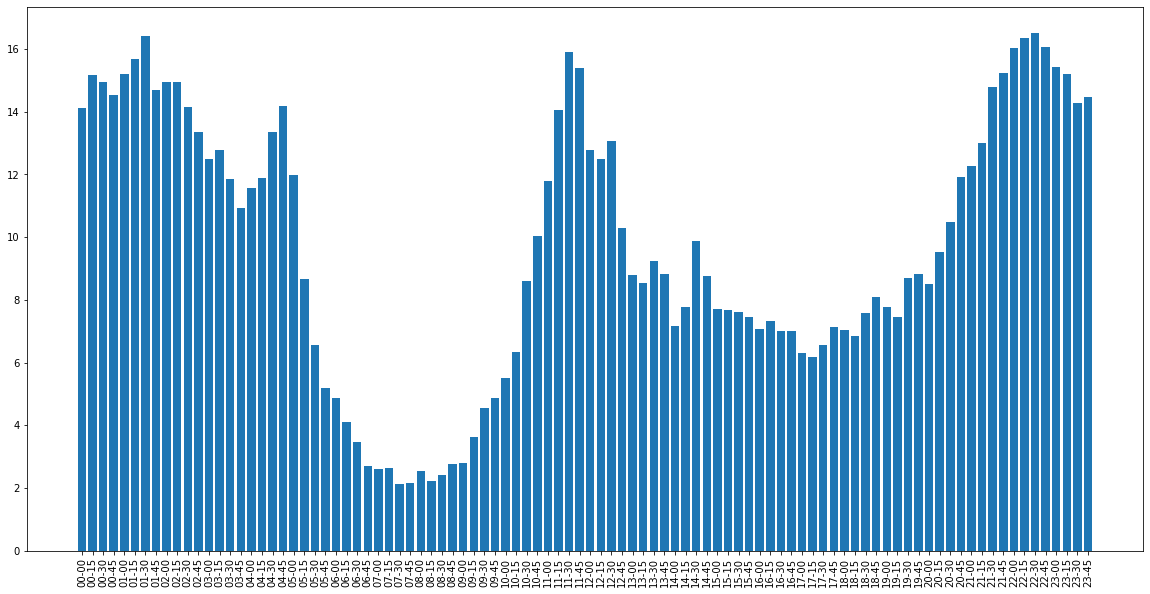

In [56]:
#Let's take a look at how the means vary of the course of a day
fig = plt.figure(figsize = (20,10))
plt.bar(intraDayGroupStats_df.index, intraDayGroupStats_df.daily_group_mean)
plt.xticks(ticks = intraDayGroupStats_df.index, labels = labelArray, rotation = 90)

So we can see that in the early hours (first five hours), logins are quite high but then dip to a low around 08:00 and then peak again 11:30. We see a dip around the 14:00 again but not as low as 08:00 and it stays around this level until 20:00 where it peaks again and goes up where it seems to go through an elevated level.

### 1.5) Conculsion

Based on our EDA analysis, we can infer the following information about our data:
* The data shows a weekly cyclical nature when measured on a day level. Basically we see a growth in logins day over day and then a drop after 7 days and the cycle continues
* The data on an aggergate day level does not appear to follow a random walk which means that when conducting a more intensive analysis on the date, it would potentialy make sense to consider an ARMIA model for time-series analysis
* If we look at the data at the intra-day level, we see there is a pattern to the data where logins are elevated betwen 21:30 through 05:00 and then dip substantially from 05:00 to 08:00 and then run up against from 08:00 through 12:00. We then see a downward trend through 17:00 and then another run up through 21:30 and the cycle continues.

## 2) Experiment & Metrics Design

The assignment is as follows:

_The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities._

_However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs._

1. _What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?_
2. _Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:_
3. _How you will implement the experiment_
4. _What statistical test(s) you will conduct to verify the significance of the observation_
5. _How you would interpret the results and provide recommendations to the city operations team along with any caveats_

### 2.1) Key Measure of Success

I will work off the assumption that both city managers assume that more inter-city travel results in economic activity gains that are worth the cost of paying the toll bridge tolls (mainly because that would be a different question to test). As a key measure of success, I would work off 'average crossings per day' as the key metric because it would allow for practical testing, and is relatively easy to track as we know tolls are collected and therefore data should be trackable. The key difference would be to consider a "before" level and an "after" level. One important aspect to consider is whether the sponsors have a "level" of success that needs to be considered as there is a difference between "an average increase per day" versus "an average increase of at least 100 or more bridge crossings per day. For now, we will assume that they simply want to see a statistically significant increase in bridge crossings.

### 2.2 - 2.3) Practical Experiment & Implementation

I would perceive this as a "A/B" style of experiment where we need to see what the baseline looks like ("A") and then determine what the post-policy data looks like ("B"). In order to establish a baseline, it would in essence be a sampling of past data to establish a "pre-policy" baseline for the number of 'average crossings per day.' One key thing to consider is that the data used should be *before this policy was made public* for two main reasons. First, If the public is made aware that a policy like this is being considered, they may alter their driving behavior in anticipation. Second, if the policy is annouced to be implemented on a specific date, then it is reasonable to assume drivers will definitely alter their behavior. As such, you'd want a baseline that wouldn't be affected by news. That said, you could use this baseline to test pre and post annoucement to see if there is any change. Once you establish this baseline, you have a means of testing the new levels with some means of measuring the change. As a note - given that we are told that each city has certain characteristics (e.g., Gotham active during the day), we could establish baselines for specific time frames. The ones that seem applicable given the information would be during the week  during the day(Monday through Friday from 08:00 to 18:00), during the week during the night (Monday through Friday from 18:00 to 08:00), and then during the weekends given that both cities are active. Once the policy is implemented successfully (we'll assume operational competency), you would collect the data and have to go through the traditional Data Science Pipeline of Data Wrangling and Exploratory Data Analysis into Statistical Analysis.

### 2.4) Statistical Test(s)

This seems like a situation where you can use a *one-sided t-test* quite effectively to test changes between two groups as we are specifically testing to see if there is an increase. This would be standard test you could run since it would work off averages. There are some other tests you could run as well to help verify the benefits. One test we could also consider is linear regression where we have features that predict bridge crossings per day (e.g., day of the week, day of the month, auto-regressive terms, etc.)  where we have a "pre" policy and "post" policy period and see if a dummy variable is that "0" at the "pre" era and "1" for the "post" policy era to see if it has an explanatory power. The coefficient (beta) of a variable like this would give us an indication of the measured effect. The last test we could conduct (depending on the level of data we collect) would be a "best match" analysis where we compare "apples to apples" changes and then average them together. For example, let's say we had one-year of "pre" data and one-year of "post" data. What we could do is compare the difference for each commesurate day (so Februaray 15th pre policy and February post policy) to measure the difference. Then, you can average those differences to get a confidence interval to measure the difference. This allows you to compare "apples to apples" as directly as possible. Using all of these tests together would allow you to build a robust measure regarding the change that occurred.

### 2.5) Recommendations & Caveats
The biggest drivers of recommendations for a program like this would have to be based on some threshold that needs to be met as I'm assuming both cities have verified that paying the cost of tolls is worth the associated economic gains. At first, we can use the results of a "one-sided t-test" to verify the aggregate change. If a t-test like this shows no signficant change, it would be strong evidence that the suggested policy is most likely ineffective and probably should be dropped. If we find changes associated with different time segements (e.g., Weekdays during the day, Weekdays during the night, Weekends, etc.) to be signficiant for some and not significant for others, recommendations would need to be tailored to the associated gains (and troubles). For example, if we find that the only period that changes would be weekdays during the night, but we also find that the cities have zero confidence it would be worth it to implement the policy for economic reasons, then we'd have to consider not recommending the policy.

In terms of caveats to consider from a statistical perspective, the biggest one would be tied to how long they are willing to let the policy run before the analysis. If the sponsor wants results to be processed quickly (i.e., before a lot of data is collected), it might be tough to be confident that an increase is actually caused by a policy change. In addition, we would potentially need to consider the "exploration bump" that may occur when people travel to a different city due to it being free. This is common with restaurants where a new restaurant opens and owners get a false sense of demand being high due to inital numbers. This is due to people being open to trying new restaurants but trying a new restaurant *rarely* translates to a restaurant entering the normal basket of a restaurants a customer returns to consistently. Thus, as time passes, demand plummets, because the new restaurant is no longer new and people don't return. We could have a similar issue with a policy like this as we see an initial bump due to people exploring "the other city" but then finding they prefer the options in their own city which results in a reversion to previous numbers. Thus, you'd need enough time to pass to be confident that the "exploration bump" had passed. In the event that you find a "exploration bump" as opposed to a consistent change, it may be evidence to consider doing a periodic deal (e.g., twice a year) to reimburse travel costs to take advantage of people wanting to go back and explore.

## 3) Predictive Modeling

The assignment is as follows:

_Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days._

_We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate._

_The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge._

_Tasks to complete:_

* _Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?_
* _Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance._
* _Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice)._

### 3.0) Data Description

_The following are the description of the data provided:_

* __city__: city this user signed up in
* __phone__: primary device for this user
* __signup_date__: date of account registration; in the form ‘YYYYMMDD’
* __last_trip_date__: the last time this user completed a trip; in the form ‘YYYYMMDD’
* __avg_dist__: the average distance in miles per trip taken in the first 30 days after signup
* __avg_rating_by_driver__: the rider’s average rating over all of their trips
* __avg_rating_of_driver__: the rider’s average rating of their drivers over all of their trips
* __surge_pct__: the percent of trips taken with surge multiplier > 1
* __avg_surge__: The average surge multiplier over all of this user’s trips
* __trips_in_first_30_days__: the number of trips this user took in the first 30 days after signing up
* __ultimate_black_user__: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
* __weekday_pct__: the percent of the user’s trips occurring during a weekday

### 3.1) Downloading & Wragling Data

Our first step is to import the data and explort it a little bit to get a sense of what we are looking at

In [57]:
with open('ultimate_data_challenge.json') as f3:
    raw_data_3 = json.load(f3)

In [58]:
raw_df_3 = pd.DataFrame(raw_data_3)

In [59]:
raw_df_3.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [60]:
# First, let's check to see if there are any missing values to consider
raw_df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


The biggest thing to consider is that 'avg_rating_of_driver' has nearly 9,000 entries missing which means that dropping that feature could result in losing nearly 20% of our data set which isn't exactly optimal. Therefore, we'll need to consider how we want to deal with the missing values as it may still be that we can simply cut them since we would still have over 40k observations to work with most likely. It may make more sense to evaluate the less sparse features first.

In [61]:
#We see that 'avg_rating_by_driver' has some missing values so we'll evaluate that feature first. 
#We've verified that it is a float object data object
raw_df_3.avg_rating_by_driver.unique()

array([5. , 4.9, 4. , 3. , 4.8, 4.7, 4.5, 4.2, nan, 4.4, 4.6, 3.7, 4.3,
       3.5, 2. , 3.8, 2.5, 4.1, 3.9, 1. , 3.3, 3.4, 3.6, 3.2, 2.3, 2.8,
       1.5, 2.7])

In [62]:
# The unique values appear sensical for the most part with only the 'nan' standing out. Given how few observations
#are NA for this feature, we'll elect to simply drop the missing values
raw_df_3['avg_rating_by_driver'].fillna(0,inplace=True)
raw_df_3_cleaning = raw_df_3.loc[raw_df_3['avg_rating_by_driver'] != 0]
raw_df_3_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49799 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49799 non-null  object 
 1   trips_in_first_30_days  49799 non-null  int64  
 2   signup_date             49799 non-null  object 
 3   avg_rating_of_driver    41744 non-null  float64
 4   avg_surge               49799 non-null  float64
 5   last_trip_date          49799 non-null  object 
 6   phone                   49406 non-null  object 
 7   surge_pct               49799 non-null  float64
 8   ultimate_black_user     49799 non-null  bool   
 9   weekday_pct             49799 non-null  float64
 10  avg_dist                49799 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [63]:
# Now let's look at the other potentially "missing" values in 'phone' which
#has some other missing values
raw_df_3_cleaning['phone'].unique()

array(['iPhone', 'Android', None], dtype=object)

In [64]:
# Given the small amount of 'None' values, we will elect to simply drop them from our data set
raw_df_3_cleaning['phone'].fillna(0,inplace=True)
raw_df_3_cleaning_2 = raw_df_3_cleaning.loc[raw_df_3_cleaning['phone'] != 0]
raw_df_3_cleaning_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49406 non-null  object 
 1   trips_in_first_30_days  49406 non-null  int64  
 2   signup_date             49406 non-null  object 
 3   avg_rating_of_driver    41445 non-null  float64
 4   avg_surge               49406 non-null  float64
 5   last_trip_date          49406 non-null  object 
 6   phone                   49406 non-null  object 
 7   surge_pct               49406 non-null  float64
 8   ultimate_black_user     49406 non-null  bool   
 9   weekday_pct             49406 non-null  float64
 10  avg_dist                49406 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


C:\Anaconda\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [65]:
# Verify the remaining values are just iPhone and Android
raw_df_3_cleaning_2['phone'].unique()

array(['iPhone', 'Android'], dtype=object)

#### Looking at 'avg_rating_of_driver'

The 'avg_rating_of_driver' feature has substantially more missing values which means that simply dropping values may not necessarily be the best option due to the amount of data loss that would occur. As such, we can briefly do a deeper dive

In [66]:
raw_df_3_cleaning_2['avg_rating_of_driver'].unique()

array([4.7, 5. , 4.3, 4.6, 4.4, 3.5, nan, 4.5, 4. , 3.9, 4.9, 4.8, 2.5,
       3.7, 1. , 4.1, 4.2, 3. , 3.8, 2. , 2.7, 3.3, 2.8, 3.6, 3.4, 3.2,
       2.6, 3.1, 2.9, 1.7, 1.8, 1.5, 2.3, 1.9, 2.1, 2.4, 1.6, 2.2])

In [67]:
raw_df_3_cleaning_2['avg_rating_of_driver'].value_counts()

5.0    20529
4.0     4147
4.5     2472
4.8     2408
4.7     1934
4.9     1757
4.3     1473
4.6     1133
3.0      985
4.4      826
4.2      598
3.5      484
3.8      428
4.1      396
3.7      363
3.9      254
1.0      251
2.0      203
3.3      200
3.6      170
3.4      108
2.5       93
3.2       53
2.7       47
3.1       38
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.7        2
1.8        2
1.9        1
1.6        1
2.2        1
Name: avg_rating_of_driver, dtype: int64

In [68]:
#Look at the general central tendency measures
print(f' The average of the feature is {raw_df_3_cleaning_2.avg_rating_of_driver.mean()}')
print(f' The median of the feature is {raw_df_3_cleaning_2.avg_rating_of_driver.median()}')
print(f' The mode of the feature is {raw_df_3_cleaning_2.avg_rating_of_driver.mode()}')

 The average of the feature is 4.601720352273912
 The median of the feature is 4.9
 The mode of the feature is 0    5.0
dtype: float64


We can see that the average is pulled down substantially by the very low values that cause the distribution to have a long left-tail. However, the median is 4.9 and the mode is 5.0 with the vast majority of ratings being 5.0.

(array([2.5100e+02, 7.0000e+00, 2.1200e+02, 1.1900e+02, 1.0000e+02,
        1.3840e+03, 1.4450e+03, 4.7970e+03, 5.3690e+03, 2.7761e+04]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

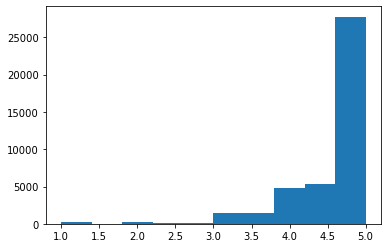

In [69]:
#Look at a simple histogram
plt.hist(raw_df_3_cleaning_2['avg_rating_of_driver'].dropna())

This leaves us with a couple of interesting questions. Given the overwhelming majority of ratings are "5.0," it would be perfectly defensible to simply imput the values with the mode. However, if there is an underlying reason why these ratings were never filled out, we may be biasing the data set in some way as we could also end up making the "5.0" rating less useful to use. In an event like this, it would probably make the most sense to reach out to the stakeholders with access to this data to see if there was an underlying reason why ratings may be missing and then adjust accordingly. Given that we have no information to go on, for the purposes of this assignment, we'll simply drop values but would note that a deeper analysis on the missing values is most likely warranted.

In [70]:
raw_df_3_cleaning_2['avg_rating_of_driver'].fillna(0,inplace=True)
raw_df_3_cleaning_CLEANED = raw_df_3_cleaning_2.loc[raw_df_3_cleaning_2['avg_rating_of_driver'] != 0]
raw_df_3_cleaning_CLEANED.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41445 non-null  object 
 1   trips_in_first_30_days  41445 non-null  int64  
 2   signup_date             41445 non-null  object 
 3   avg_rating_of_driver    41445 non-null  float64
 4   avg_surge               41445 non-null  float64
 5   last_trip_date          41445 non-null  object 
 6   phone                   41445 non-null  object 
 7   surge_pct               41445 non-null  float64
 8   ultimate_black_user     41445 non-null  bool   
 9   weekday_pct             41445 non-null  float64
 10  avg_dist                41445 non-null  float64
 11  avg_rating_by_driver    41445 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.8+ MB


We now have a data set with no missing values which means we can begin EDA and feature engineering to make it viable for use with our ML algorithms

### Formatting features to make them usable in ML algorithms

#### Let's create some dummy variables for 'city

In [71]:
# Let's first get a sense of the 'city feaure'
raw_df_3_cleaning_CLEANED.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [72]:
raw_df_3_cleaning_CLEANED.city.value_counts()

Winterfell        19161
Astapor           13509
King's Landing     8775
Name: city, dtype: int64

In [73]:
raw_df_3_cleaning_CLEANED

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49993,Astapor,3,2014-01-03,4.8,1.11,2014-07-01,iPhone,11.1,True,55.6,2.53,4.7
49994,Astapor,1,2014-01-03,4.6,1.44,2014-05-31,iPhone,37.5,False,25.0,2.25,4.5
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0


In [74]:
#Get city dummies
dummies_df = pd.get_dummies(raw_df_3_cleaning_CLEANED.city, prefix='city', prefix_sep='_')

#Append to DataFrame
holder_df = pd.concat([raw_df_3_cleaning_CLEANED,dummies_df],axis=1)

#Check
holder_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0,1,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,1,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1,0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,0,1,0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,0,1


#### Now let's create dummies for 'phone

In [75]:
#Get city dummies
dummies_df = pd.get_dummies(raw_df_3_cleaning_CLEANED.phone, prefix='phone', prefix_sep='_')

#Append to DataFrame
holder_df = pd.concat([holder_df,dummies_df],axis=1)

#Check
holder_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0,1,0,0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,1,0,0,1,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1,0,0,0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,0,1,0,0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,0,1,1,0


#### Let's convert the 'ultimate_black_user' category to binary variables

In [76]:
holder_df['ultimate_black_user'] = np.multiply(holder_df['ultimate_black_user'],1)

In [77]:
holder_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,0,1,0,0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,1,0,0,1,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,1,0,0,0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,0,1,0,0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0,0,1,1,0


In [78]:
holder_df['trips_in_first_30_days'].value_counts()

0      11524
1       9953
2       7014
3       3714
4       2541
5       1604
6       1128
7        814
8        584
9        470
10       346
11       297
12       218
13       168
15       154
14       144
17       113
16       106
18        80
19        68
20        51
23        44
21        38
22        34
24        33
27        27
28        21
25        19
26        19
30        15
34        11
29         9
37         9
33         9
32         8
31         6
44         5
40         5
43         4
38         4
39         3
36         3
47         3
42         3
53         2
48         2
49         2
55         2
35         2
54         2
56         2
71         1
73         1
125        1
41         1
50         1
63         1
51         1
58         1
Name: trips_in_first_30_days, dtype: int64

I checked with the client to verify their definition of a "retained user" and they agreed it was if a user took a trip in the first 30 days as described by this feature. Therefore, we can convert it to a binary feature that is effectively our outcome feature of "retained" or "not retained." Therefore, we will create a binary variable to capture this information.

In [79]:
#create our "retained_user" outcome feature
holder_df['retained_user'] = holder_df['trips_in_first_30_days'].apply(lambda x: 1 if x > 0 else 0)

In [80]:
holder_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,retained_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,0,1,0,0,1,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,1,0,0,1,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,1,0,0,0,1,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,0,1,0,0,1,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0,0,1,1,0,1


In [81]:
holder_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41445 non-null  object 
 1   trips_in_first_30_days  41445 non-null  int64  
 2   signup_date             41445 non-null  object 
 3   avg_rating_of_driver    41445 non-null  float64
 4   avg_surge               41445 non-null  float64
 5   last_trip_date          41445 non-null  object 
 6   phone                   41445 non-null  object 
 7   surge_pct               41445 non-null  float64
 8   ultimate_black_user     41445 non-null  int32  
 9   weekday_pct             41445 non-null  float64
 10  avg_dist                41445 non-null  float64
 11  avg_rating_by_driver    41445 non-null  float64
 12  city_Astapor            41445 non-null  uint8  
 13  city_King's Landing     41445 non-null  uint8  
 14  city_Winterfell         41445 non-null

Based on current data, we have enough to move forward with processing. Our outcome features is 'retained_user' and we have features that we can use for predictive modeling. However, it may behoove use to do some EDA to get a better sense of the relations in our data before moving to predictive modeling.

#### Exploratory Data Analysis

We can beign with a simple .describe() analysis of our data

In [82]:
holder_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,retained_user
count,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000
mean,2.609675,4.601720,1.073822,8.898709,0.384099,61.254897,5.460046,4.776446,0.325950,0.211726,0.462324,0.291784,0.708216,0.721945
std,4.059336,0.616104,0.198747,18.322061,0.486387,34.813848,5.145174,0.404606,0.468734,0.408537,0.498584,0.454589,0.454589,0.448046
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,0.000000,37.500000,2.420000,4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,0.000000,66.700000,3.780000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,3.000000,5.000000,1.070000,11.100000,1.000000,100.000000,6.490000,5.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,1.000000,100.000000,79.690000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can glean some information about our data set from this report alone:
* Features like 'surge_pct' and 'ultimate_back_user' are not close to to 50/50 in terms of spread which we may need to consider.
* Some features could use with a bit of scaling consideraiton. For example, 'avg_surge' has a max value of 8 while 'surge_pct' has a max value of 100.
* We actually have more retained users than not retained users in terms of percentage

Another way we can explore our data is with a correlation heatmap

In [83]:
#let's make a df that will allow us to explore the corrleation between being a retained user and our predictive features
corr_df = holder_df[['avg_rating_of_driver','avg_surge','surge_pct','ultimate_black_user',
                    'weekday_pct','avg_dist','avg_rating_by_driver','city_Astapor',"city_King's Landing",
                    'city_Winterfell','phone_Android','retained_user']]

<AxesSubplot:>

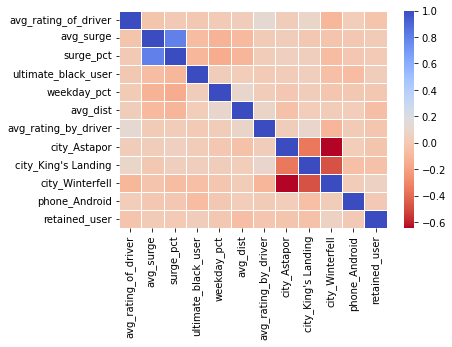

In [84]:
#Now let's make a correlation heatmap
sns.heatmap(corr_df.corr(),cmap='coolwarm_r', linewidths = 0.5)

When looking at the heatmap and evaluating the correlations with 'retained_user', it doesn't appear that any particular feature stands out more than any other feature, which would imply that our ability to make a strong predictive model may be somewhat limited. That said, we can check a few of these features to gain a better sense of some of these correlations.

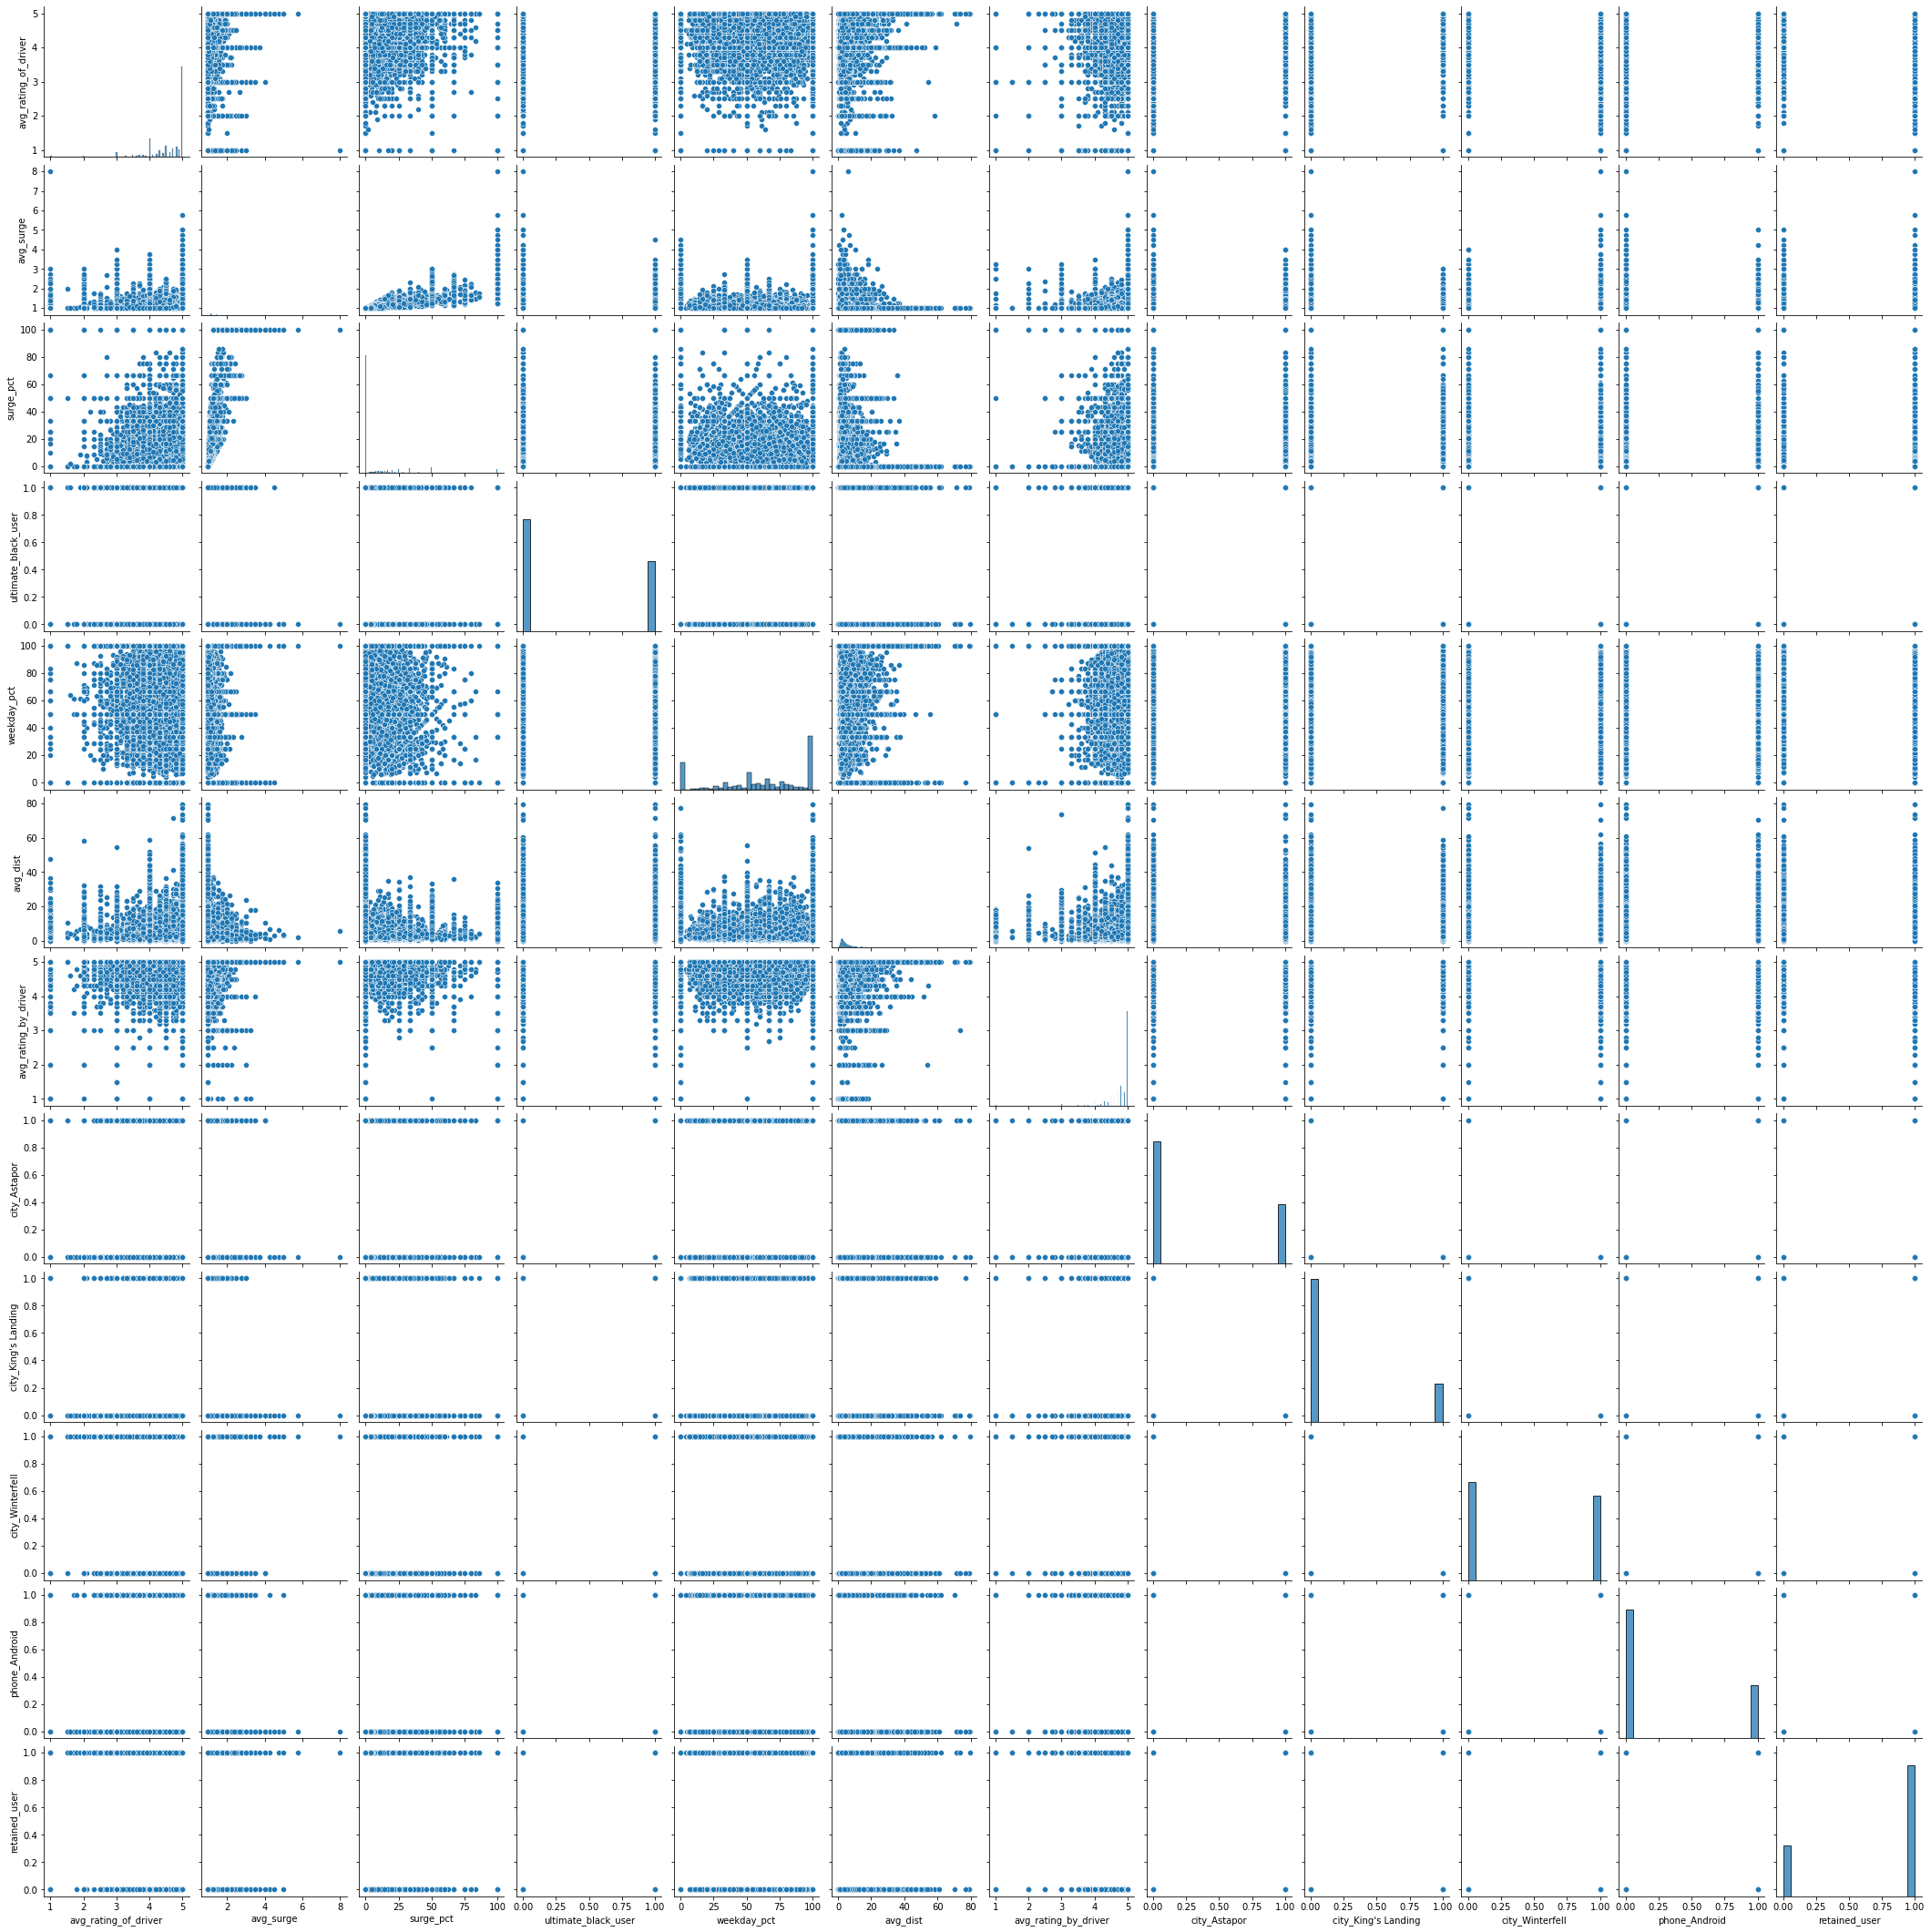

In [85]:
#Let's check a pairplot to see if there is anything we can glean
sns.pairplot(corr_df)

Similar to our correlation heat map, it doesn't appear that there is much on its own that really stands out. As such, let's move to modeling. Since we are working with a binary classification problem, we'll select models based on this

### Modeling 0 - Naive Guess

In [86]:
holder_df['retained_user'].mean()

0.7219447460489806

This gives us a good baseline to work from in that a naive classifer that simply classifies all observations as "retained" would  technically have an accuracy score of 72.19%. Therefore, if we want our predictive model to be meangingful, we will want to be substantially above this amount. A score of 80% or higher (the traditional benchmark) will probably be what we'll aim for a model to keep it.

One thing we need to consider as well is data leakage since we should only begin any processing of data once we've done our train test split. As such, let's first split our data by predictor features and outcome feature 

In [87]:
# Import relevant packages
from sklearn.model_selection import train_test_split

In [88]:
# Seperate our data
y = holder_df['retained_user']
X = holder_df.drop(['retained_user'], axis = 1)

In [89]:
# Let's evaluate which features we are actually going to keep from X as some are not worth keeping
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    41445 non-null  object 
 1   trips_in_first_30_days  41445 non-null  int64  
 2   signup_date             41445 non-null  object 
 3   avg_rating_of_driver    41445 non-null  float64
 4   avg_surge               41445 non-null  float64
 5   last_trip_date          41445 non-null  object 
 6   phone                   41445 non-null  object 
 7   surge_pct               41445 non-null  float64
 8   ultimate_black_user     41445 non-null  int32  
 9   weekday_pct             41445 non-null  float64
 10  avg_dist                41445 non-null  float64
 11  avg_rating_by_driver    41445 non-null  float64
 12  city_Astapor            41445 non-null  uint8  
 13  city_King's Landing     41445 non-null  uint8  
 14  city_Winterfell         41445 non-null

* We can drop the 'city' feature as it is captured by the two other features associted with 'city'. We'll drop city "Kings_landing" as well and make that the base
* We can drop 'phone' and 'iPhone' and simply make it the base
* Since our client cannot act on the 'signup' date or 'last_trip_date', we can drop these features as well
* 'trips in first 30 days translates to our outcome so we can drop that feature as well

In [90]:
# Make a new X that is clear of the features we will be dropping
X_trim = X.drop(['city', "city_King's Landing",'phone','phone_iPhone','signup_date','last_trip_date','trips_in_first_30_days'],axis=1)

In [91]:
X_trim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avg_rating_of_driver  41445 non-null  float64
 1   avg_surge             41445 non-null  float64
 2   surge_pct             41445 non-null  float64
 3   ultimate_black_user   41445 non-null  int32  
 4   weekday_pct           41445 non-null  float64
 5   avg_dist              41445 non-null  float64
 6   avg_rating_by_driver  41445 non-null  float64
 7   city_Astapor          41445 non-null  uint8  
 8   city_Winterfell       41445 non-null  uint8  
 9   phone_Android         41445 non-null  uint8  
dtypes: float64(6), int32(1), uint8(3)
memory usage: 3.5 MB


### Pre-processing: Scaling

In order to make our models more efficient, we'll scale our data to make it work better with certain models. In this case, a MinMaxScaler should meet our needs. The reason why we do our scaling *after* doing our testing and training split is to avoid data leakage

In [92]:
# Import relevant packages
from sklearn.preprocessing import MinMaxScaler

In [93]:
# Let's keep a keylist of our dataframe
keyList = X_trim.columns.values.tolist()

In [94]:
# Create scaler
MMscaler = MinMaxScaler()

# Second, let's fit it
MMscaler.fit_transform(X_trim)

# Third, let's check out data
print(MMscaler.fit_transform(X_trim))

[[0.925      0.01428571 0.154      ... 0.         0.         0.        ]
 [1.         0.         0.         ... 1.         0.         1.        ]
 [0.825      0.         0.         ... 1.         0.         0.        ]
 ...
 [1.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         1.         1.        ]
 [0.5        0.         0.         ... 1.         0.         0.        ]]


In [95]:
X_trim_MMscaled = pd.DataFrame(MMscaler.fit_transform(X_trim),columns=keyList)
X_trim_MMscaled

,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_Winterfell,phone_Android
0,0.925,0.014286,0.154,1.0,0.462,0.046053,1.000,0.0,0.0,0.0
1,1.000,0.000000,0.000,0.0,0.500,0.103652,1.000,1.0,0.0,1.0
2,0.825,0.000000,0.000,0.0,1.000,0.009662,1.000,1.0,0.0,0.0
3,0.900,0.020000,0.200,1.0,0.800,0.029615,0.975,0.0,0.0,0.0
4,0.850,0.027143,0.118,0.0,0.824,0.039277,0.975,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
41440,0.950,0.015714,0.111,1.0,0.556,0.031748,0.925,1.0,0.0,0.0
41441,0.900,0.062857,0.375,0.0,0.250,0.028234,0.875,1.0,0.0,0.0
41442,1.000,0.000000,0.000,0.0,1.000,0.070649,0.800,0.0,0.0,0.0
41443,1.000,0.000000,0.000,1.0,1.000,0.048438,1.000,0.0,1.0,1.0


#### Model 1: Logistic Regression

Logistic Regression gives us a good "baseline" model to see how well it will do with something simple and interpreable. We'll also have to split our data

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [97]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split (X_trim_MMscaled, y, test_size = 0.2 , random_state = 15)

In [98]:
#let's use GridSearchCV determine our regularization parameter of C and create a Logistic Regression Model
Cs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
params = {'C':Cs}

#Instantiate our Logsistic Regression Object
logModel = LogisticRegression()

#Conduct GridSearch
logModel_opt = GridSearchCV(logModel, params)
logModel_opt.fit(X_train,y_train)
logModel_best = logModel_opt.best_estimator_

#Display the best params
f'The best C parameter is: {logModel_opt.best_params_}'

"The best C parameter is: {'C': 0.1}"

In [99]:
logModel_best.score(X_test,y_test)

0.7210761249849198

In [100]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

logPrecisionScore = precision_score(y_test,logModel_best.predict(X_test))
logRecallScore = recall_score(y_test,logModel_best.predict(X_test))

print(f'Logistic Regression Precision score is: {logPrecisionScore}')
print(f'Logistic Regression Recall score is: {logRecallScore}')

Logistic Regression Precision score is: 0.7210621605310803
Logistic Regression Recall score is: 0.9998326359832636


That's not good...Our Logistic Regression model performed worse than the naive guess. However, it does very well with Recall and in terms of precision, it still doing decent.

Let's try a Random Forest Classifier Model

#### Model 2: Random Forest Classifier

In [101]:
#import relevant packages
from sklearn.ensemble import RandomForestClassifier

In [102]:
#Setup ranges for GridSearchCV to check
n_ests = list(range(50,150))
max_dep = list(range(2,5))
params = {'n_estimators':n_ests,'max_depth':max_dep}


#Instantiate RFC
rfc = RandomForestClassifier()

#Check RFC models
rfc_opt = GridSearchCV(rfc,params)
rfc_opt.fit(X_train,y_train)
rfc_best = rfc_opt.best_estimator_

#Display the best params
f'The best parameters are: {rfc_opt.best_params_}'

"The best parameters are: {'max_depth': 2, 'n_estimators': 50}"

In [103]:
#Now let's score our best RFC model
rfc_best.score(X_test,y_test)

0.720834841356014

In [104]:
rfcPrecisionScore = precision_score(y_test,rfc_best.predict(X_test))
rfcRecallScore = recall_score(y_test,rfc_best.predict(X_test))

print(f'Random Forest Classifier Precision score is: {rfcPrecisionScore}')
print(f'Random Forest Classifier Recall score is: {rfcRecallScore}')

Random Forest Classifier Precision score is: 0.720834841356014
Random Forest Classifier Recall score is: 1.0


Once against, the RFC does worse than simply doing a naive guess in terms of accuracy. It does have perfect recall though and is more or less capable of having a pretty high accurarcy score. As such, we'll stick the Random Forest Classifier as our predominate model

In [105]:
# Let's figure out the importance of features from this model
feature_imp = pd.Series(rfc_best.feature_importances_, index = X_trim_MMscaled.columns).sort_values(ascending=False)
feature_imp

avg_rating_by_driver    0.345834
weekday_pct             0.220101
surge_pct               0.198028
avg_surge               0.102829
avg_rating_of_driver    0.056269
avg_dist                0.035387
city_Winterfell         0.031412
ultimate_black_user     0.008848
city_Astapor            0.000693
phone_Android           0.000599
dtype: float64

In [106]:
#Let's take the first 8 features to see if there is anything discernable from the first 8 values
feature_imp_CLEANED = feature_imp[0:8]
feature_imp_CLEANED

avg_rating_by_driver    0.345834
weekday_pct             0.220101
surge_pct               0.198028
avg_surge               0.102829
avg_rating_of_driver    0.056269
avg_dist                0.035387
city_Winterfell         0.031412
ultimate_black_user     0.008848
city_Astapor            0.000693
phone_Android           0.000599
dtype: float64

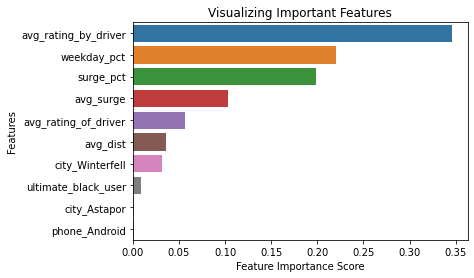

In [107]:
#Let's make a visualization of these result
sns.barplot(x=feature_imp_CLEANED, y=feature_imp_CLEANED.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

We can see that top 4 features which have the most predictive power are avg_rating_by_driver, weekday_pct, surge_pct, and avg_surge. Therefore, we'd recommend the sponsor focus on these categories the most.